In [10]:
import os
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import string
import collections
import torch
import torch.nn as nn
from torch.autograd import Variable
from pandas_datareader import data as web
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [11]:
dates = pd.date_range('2013-01-02','2017-12-29',freq='B')
df1=pd.DataFrame(index=dates)

df_ibm = pd.read_csv('AAPL.csv', parse_dates=True, index_col=0)
df_stock = df1.join(df_ibm)

df_stock

,Open,High,Low,Close,Adj Close,Volume
2013-01-02,79.117142,79.285713,77.375717,78.432854,68.687538,140129500.0
2013-01-03,78.268570,78.524284,77.285713,77.442856,67.820526,88241300.0
2013-01-04,76.709999,76.947144,75.118568,75.285713,65.931404,148583400.0
2013-01-07,74.571426,75.614288,73.599998,74.842857,65.543602,121039100.0
2013-01-08,75.601425,75.984283,74.464287,75.044289,65.719994,114676800.0
...,...,...,...,...,...,...
2017-12-25,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-26,170.800003,171.470001,169.679993,170.570007,165.167572,33185500.0
2017-12-27,170.100006,170.779999,169.710007,170.600006,165.196625,21498200.0
2017-12-28,171.000000,171.850006,170.479996,171.080002,165.661407,16480200.0


## Visualization

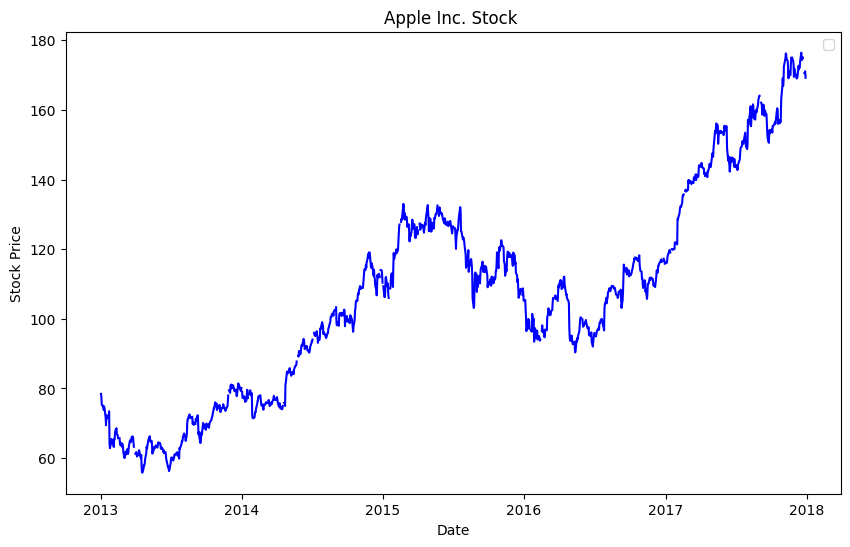

In [12]:

plt.figure(figsize=(10, 6))
plt.plot(df_stock['Close'], color='blue')
plt.title('Apple Inc. Stock ')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Data Preprocessing

In [13]:
from sklearn.preprocessing import MinMaxScaler
df_stock = df_stock[['Close']]

df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2013-01-02 to 2017-12-29
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1259 non-null   float64
dtypes: float64(1)
memory usage: 52.6 KB


In [14]:

df_stock['Close'].fillna(method='ffill', inplace=True)

scaler = MinMaxScaler(feature_range=(-1, 1))
df_stock['Close'] = scaler.fit_transform(df_stock[['Close']])


df_stock

<ipython-input-14-6f26bd374cae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['Close'].fillna(method='ffill', inplace=True)
<ipython-input-14-6f26bd374cae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['Close'] = scaler.fit_transform(df_stock[['Close']])


,Close
2013-01-02,-0.624590
2013-01-03,-0.641004
2013-01-04,-0.676768
2013-01-07,-0.684111
2013-01-08,-0.680771
...,...
2017-12-25,0.976623
2017-12-26,0.903009
2017-12-27,0.903507
2017-12-28,0.911465


## Data Splitting


In [15]:
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    return [x_train, y_train, x_test, y_test]
look_back = 60
x_train, y_train, x_test, y_test = load_data(df_stock, look_back)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (994, 59, 1)
y_train shape: (994, 1)
x_test shape: (249, 59, 1)
y_test shape: (249, 1)


In [16]:
# Make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## LSTM Model Creation

In [17]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)


LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## Training and Testing

In [18]:


num_epochs = 100
hist = np.zeros(num_epochs)
seq_dim =look_back-1
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if (t+1) % 10 == 0 and t !=0:
        print("Epoch ", t+1, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch  10 MSE:  0.053693290799856186
Epoch  20 MSE:  0.015906795859336853
Epoch  30 MSE:  0.0067415921948850155
Epoch  40 MSE:  0.0027017120737582445
Epoch  50 MSE:  0.002010141499340534
Epoch  60 MSE:  0.0017366900574415922
Epoch  70 MSE:  0.0016134461620822549
Epoch  80 MSE:  0.0015363105339929461
Epoch  90 MSE:  0.001477532903663814
Epoch  100 MSE:  0.0014298770111054182


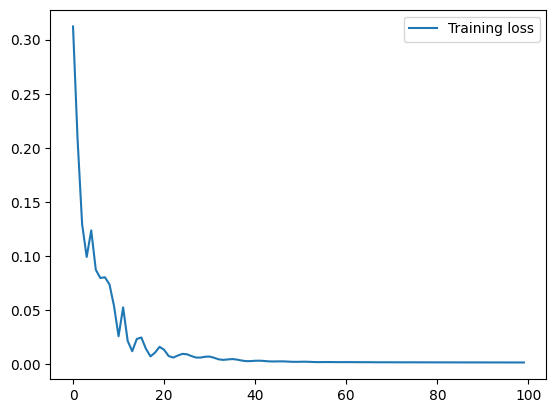

In [19]:

plt.plot(hist, label='Training loss')
plt.legend()
plt.show()

In [20]:
#  Make predictions
y_test_pred = model(x_test)
# Convert PyTorch tensors to numpy arrays
y_train_pred_numpy = y_train_pred.detach().numpy() if not isinstance(y_train_pred, np.ndarray) else y_train_pred
y_train_numpy = y_train.detach().numpy() if not isinstance(y_train, np.ndarray) else y_train
y_test_pred_numpy = y_test_pred.detach().numpy() if not isinstance(y_test_pred, np.ndarray) else y_test_pred
y_test_numpy = y_test.detach().numpy() if not isinstance(y_test, np.ndarray) else y_test

#  Invert predictions to bring back to original scale
y_train_pred = scaler.inverse_transform(y_train_pred_numpy)
y_train = scaler.inverse_transform(y_train_numpy)
y_test_pred = scaler.inverse_transform(y_test_pred_numpy)
y_test = scaler.inverse_transform(y_test_numpy)

#  Calculate root mean squared error for train and test data
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
testScore = math.sqrt(mean_squared_error(y_test, y_test_pred))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.28 RMSE
Test Score: 9.66 RMSE


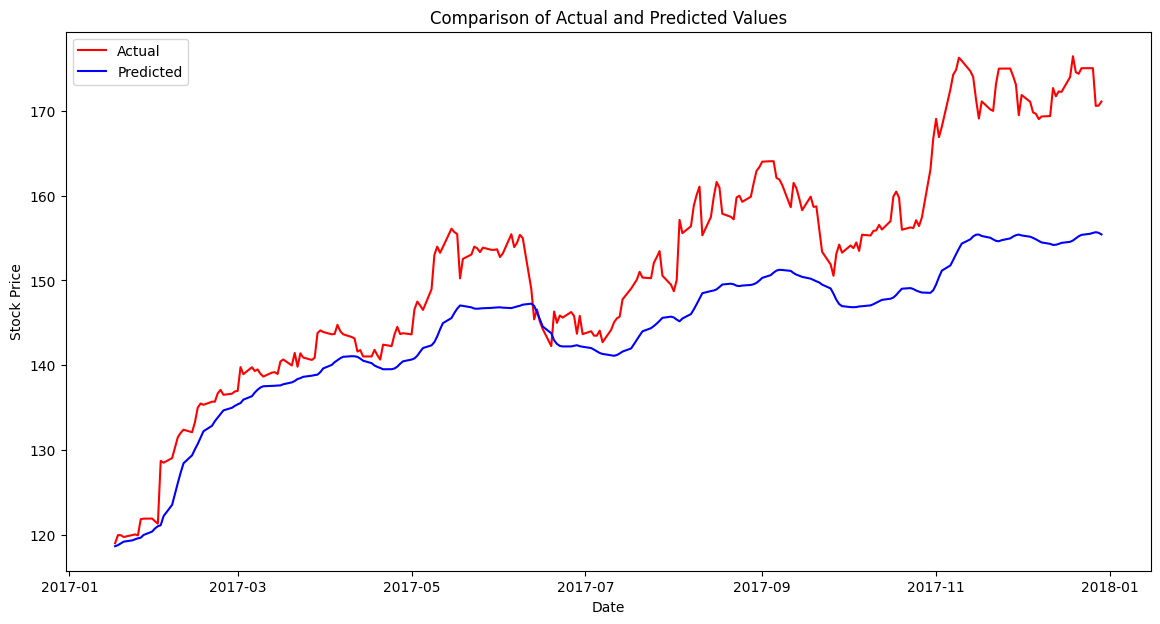

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
# Convert to DataFrame for easier plotting
test_results = pd.DataFrame(data={
    'Original': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
}, index=df_stock[len(df_stock)-len(y_test):].index)
# Plotting the results
plt.figure(figsize=(14,7))
plt.plot(test_results['Original'], color='red', label='Actual')
plt.plot(test_results['Predicted'], color='blue', label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [23]:
y_test = y_test.detach().numpy() if isinstance(y_test, torch.Tensor) else y_test
y_test_pred = y_test_pred.detach().numpy() if isinstance(y_test_pred, torch.Tensor) else y_test_pred
# Create a DataFrame for dates
dates = df_stock[len(df_stock)-len(y_test):].index.to_series().reset_index(drop=True)

# Create a DataFrame from the original and predicted values
comparison_df = pd.DataFrame({
    'Date': dates,
    'Original': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
})

# Display the DataFrame
comparison_df

,Date,Original,Predicted
0,2017-01-17,119.040001,118.692261
1,2017-01-18,120.000000,118.819473
2,2017-01-19,119.989998,119.021690
3,2017-01-20,119.779999,119.230133
4,2017-01-23,120.000000,119.378922
...,...,...,...
244,2017-12-25,175.009995,155.502258
245,2017-12-26,175.009995,155.606918
246,2017-12-27,170.570007,155.688309
247,2017-12-28,170.599991,155.620132


In [24]:
# Assuming `y_test` and `y_test_pred` are available as numpy arrays

# Generate the date range for the test set
test_dates = pd.to_datetime(df_stock[len(df_stock)-len(y_test):].index)

# Format the dates as strings in the format 'YYYY-MM-DD'
date_strings = test_dates.strftime('%Y-%m-%d').tolist()

# Create a DataFrame with the dates, original values, and predicted values
comparison_df = pd.DataFrame({
    'Date': date_strings,
    'Original': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
})

# Display the DataFrame
comparison_df

,Date,Original,Predicted
0,2017-01-17,119.040001,118.692261
1,2017-01-18,120.000000,118.819473
2,2017-01-19,119.989998,119.021690
3,2017-01-20,119.779999,119.230133
4,2017-01-23,120.000000,119.378922
...,...,...,...
244,2017-12-25,175.009995,155.502258
245,2017-12-26,175.009995,155.606918
246,2017-12-27,170.570007,155.688309
247,2017-12-28,170.599991,155.620132


Improving the accuracy of stock price prediction models, such as LSTM networks used for time series analysis, can be challenging due to the inherent unpredictability of financial markets. However, there are several strategies that you can employ to potentially enhance model performance:

Feature Engineering:

Time Features: Include features like day of the week, month, or other cyclical factors that might influence stock prices.
Technical Indicators: Use technical indicators that traders commonly use (e.g., moving averages, RSI, MACD) as additional features.
External Data: Incorporate external data that could affect stock prices, such as economic indicators, news sentiment analysis, or market volatility indexes.
Model Complexity:

Layer Adjustments: Experiment with adding more LSTM layers or adjusting the number of neurons in the layers to increase model complexity.
Bidirectional LSTM: Use bidirectional LSTMs to capture patterns from both forward and backward sequences of data.
Hyperparameter Tuning:

Learning Rate: Optimize the learning rate; sometimes smaller learning rates with decay over epochs can converge better.
Epochs and Batch Size: Adjust the number of epochs and batch size for better generalization.
Optimizer: Try different optimizers like Adam, RMSprop, or SGD with momentum to see which works best for your data.
Regularization Techniques:

Dropout: Apply dropout layers to reduce overfitting.
Early Stopping: Implement early stopping during training to prevent overfitting to the training data.
Cross-Validation:

Time Series Split: Use time-series cross-validation to evaluate the model's performance on different time periods.
Loss Function:

Custom Losses: Experiment with custom loss functions that might better capture the behavior of stock prices.
Training Strategy:

Sequence Length: Experiment with different sequence lengths to see how much past information the model needs to predict future prices.
Gradient Clipping: Use gradient clipping to prevent exploding gradients which can lead to unstable training.
Ensemble Methods:

Multiple Models: Build ensemble models that average predictions from several independent models to reduce variance.
Backtesting:

Realistic Simulation: Backtest your model with historical data using a realistic simulation of trading to understand how the model might perform in real-world trading.
Model Evaluation:

Profitability: Instead of only looking at RMSE or MAE, evaluate the model based on profitability metrics if the end goal is trading.
Remember that the stock market is influenced by a large number of factors, many of which cannot be captured by historical price data alone. It's essential to understand the limitations of your model and the risk associated with using predictions for actual trading. Stock market predictions should be used with caution and always with an understanding of the underlying financial risks.

To implement the suggestions for hyperparameter tuning in your stock price prediction model, you will need to adjust the relevant parts of your code. Here's what you should change for each of the suggestions:

Learning Rate:

Change the learning rate when initializing the optimizer. For a learning rate decay, you can use learning rate schedulers available in torch.optim.lr_scheduler.
python
Copy code
learning_rate = 0.01  # You can try different values for this
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)  # Example scheduler
Then, within your training loop, you will update the learning rate at the end of each epoch:

python
Copy code
for t in range(num_epochs):
    # Training steps...
    scheduler.step()
Epochs and Batch Size:

Adjust the num_epochs variable to increase or decrease the number of epochs.
python
Copy code
num_epochs = 100  # Adjust this number based on your experiment
Change the batch size when creating your data loaders (if you're using them). If you're not using data loaders and are instead feeding the entire dataset at once, consider implementing them for better memory management and model performance.
python
Copy code
batch_size = 32  # Try different batch sizes
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # For time series, shuffle is usually False
Optimizer:

Change the optimizer by creating a new instance of a different optimizer class.
python
Copy code
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam
# or
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  # RMSprop
# or
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # SGD with momentum
Remember, when you adjust any of these parameters, you may need to retune the others, as they can interact in complex ways. For example, a smaller learning rate might require more epochs to converge, and a larger batch size might require adjusting the learning rate.

Lastly, always keep track of the changes you make and systematically experiment with different combinations of hyperparameters. Use a validation set to evaluate the impact of your changes without overfitting to the test set.

**Enhanced LSTM MODEL**

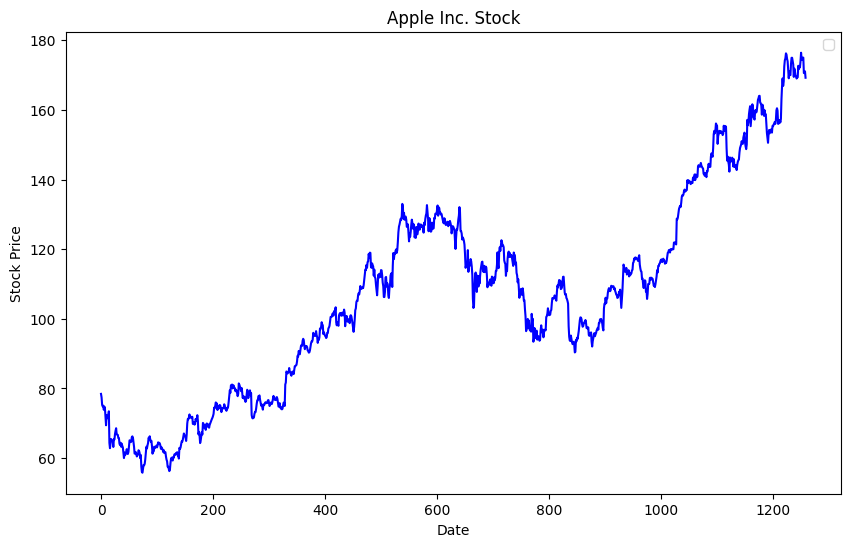

<ipython-input-25-f532b8f815bb>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['Close'].fillna(method='ffill', inplace=True)
<ipython-input-25-f532b8f815bb>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['Close'] = scaler.fit_transform(df_stock[['Close']])


EnhancedLSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Epoch 10 MSE: 0.048691317439079285
Epoch 20 MSE: 0.008389630354940891
Epoch 30 MSE: 0.0030933297239243984
Epoch 40 MSE: 0.003071193117648363
Epoch 50 MSE: 0.002070908434689045
Epoch 60 MSE: 0.0018343235133215785
Epoch 70 MSE: 0.0016014319844543934
Epoch 80 MSE: 0.001486589084379375
Epoch 90 MSE: 0.001388450851663947
Epoch 100 MSE: 0.00137308519333601


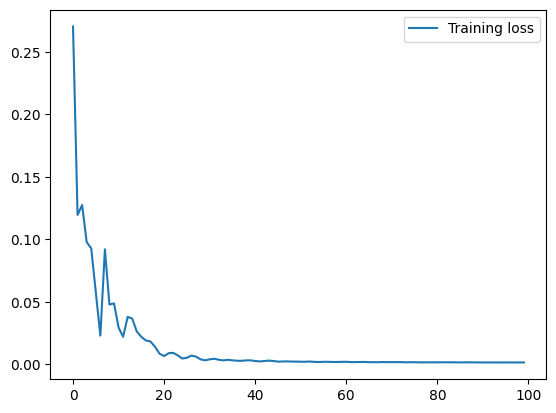

Train Score: 2.23 RMSE
Test Score: 11.72 RMSE


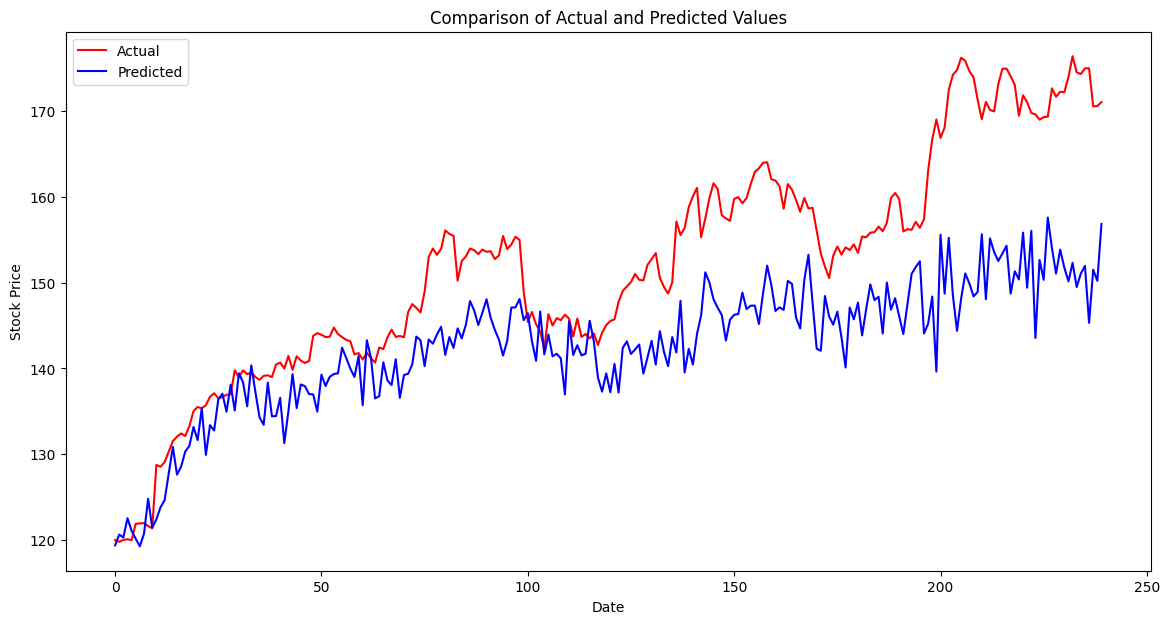

In [25]:
import os
import numpy as np
import pandas as pd
from pylab import mpl, plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Set matplotlib to display inline
%matplotlib inline

# Load the AAPL Stock Pricing Dataset

df_stock = pd.read_csv('AAPL.csv')
plt.figure(figsize=(10, 6))
plt.plot(df_stock['Close'], color='blue')
plt.title('Apple Inc. Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Data Preprocessing
df_stock = df_stock[['Close']]
df_stock['Close'].fillna(method='ffill', inplace=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
df_stock['Close'] = scaler.fit_transform(df_stock[['Close']])

# Data Splitting
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size, :-1]
    y_train = data[:train_set_size, -1]
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1]
    return [x_train, y_train, x_test, y_test]

look_back = 60
x_train, y_train, x_test, y_test = load_data(df_stock, look_back)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# Enhanced LSTM Model
class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.5):
        super(EnhancedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,
                            dropout=dropout_prob, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
dropout_prob = 0.3
model = EnhancedLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob=dropout_prob)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

# Training
num_epochs = 100
hist = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if (t+1) % 10 == 0:
        print(f"Epoch {t+1} MSE: {loss.item()}")
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(hist, label='Training loss')
plt.legend()
plt.show()

# Testing
y_test_pred = model(x_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

trainScore = sqrt(mean_squared_error(y_train, y_train_pred))
testScore = sqrt(mean_squared_error(y_test, y_test_pred))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

# Visualization
test_results = pd.DataFrame({
    'Original': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
})
plt.figure(figsize=(14, 7))
plt.plot(test_results['Original'], color='red', label='Actual')
plt.plot(test_results['Predicted'], color='blue', label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**New Model**

In [26]:
import os
import numpy as np
import pandas as pd
from pylab import mpl, plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Set matplotlib to display inline
%matplotlib inline



In [28]:
# Load the AAPL Stock Pricing Dataset
dates = pd.date_range('2013-01-02','2017-12-29',freq='B')
df1=pd.DataFrame(index=dates)

df_ibm = pd.read_csv('AAPL.csv', parse_dates=True, index_col=0)
df_stock = df1.join(df_ibm)

df_stock

,Open,High,Low,Close,Adj Close,Volume
2013-01-02,79.117142,79.285713,77.375717,78.432854,68.687538,140129500.0
2013-01-03,78.268570,78.524284,77.285713,77.442856,67.820526,88241300.0
2013-01-04,76.709999,76.947144,75.118568,75.285713,65.931404,148583400.0
2013-01-07,74.571426,75.614288,73.599998,74.842857,65.543602,121039100.0
2013-01-08,75.601425,75.984283,74.464287,75.044289,65.719994,114676800.0
...,...,...,...,...,...,...
2017-12-25,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-26,170.800003,171.470001,169.679993,170.570007,165.167572,33185500.0
2017-12-27,170.100006,170.779999,169.710007,170.600006,165.196625,21498200.0
2017-12-28,171.000000,171.850006,170.479996,171.080002,165.661407,16480200.0


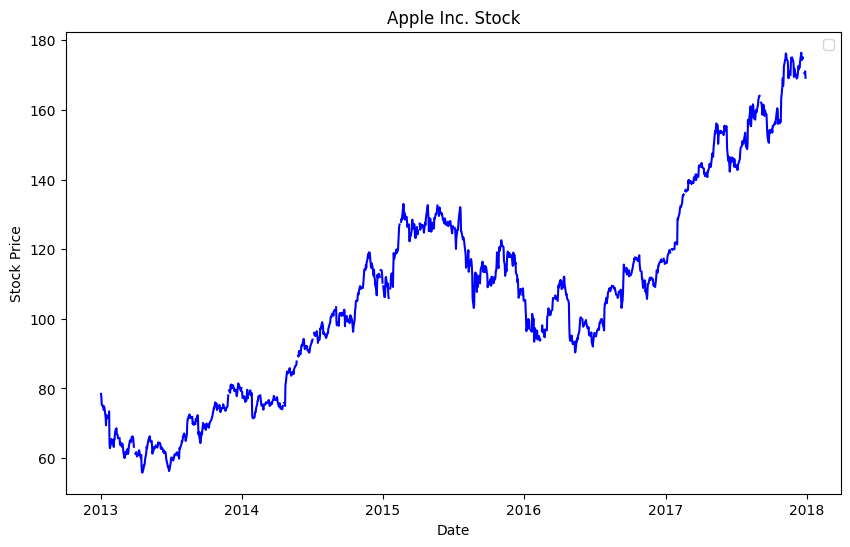

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(df_stock['Close'], color='blue')
plt.title('Apple Inc. Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



In [30]:
# Data Preprocessing
df_stock = df_stock[['Close']]
df_stock['Close'].fillna(method='ffill', inplace=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
df_stock['Close'] = scaler.fit_transform(df_stock[['Close']])

# Data Splitting
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size, :-1]
    y_train = data[:train_set_size, -1]
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1]
    return [x_train, y_train, x_test, y_test]

look_back = 60
x_train, y_train, x_test, y_test = load_data(df_stock, look_back)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)





<ipython-input-30-98f9a0f8fa78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['Close'].fillna(method='ffill', inplace=True)
<ipython-input-30-98f9a0f8fa78>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['Close'] = scaler.fit_transform(df_stock[['Close']])


In [31]:
# Enhanced LSTM Model
class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.5):
        super(EnhancedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,
                            dropout=dropout_prob, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
dropout_prob = 0.3
model = EnhancedLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob=dropout_prob)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

EnhancedLSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 10 MSE: 0.07394024729728699
Epoch 20 MSE: 0.008108779788017273
Epoch 30 MSE: 0.002730712527409196
Epoch 40 MSE: 0.0019201601389795542
Epoch 50 MSE: 0.001714667771011591
Epoch 60 MSE: 0.0015806807205080986
Epoch 70 MSE: 0.0014972047647461295
Epoch 80 MSE: 0.0015159936156123877
Epoch 90 MSE: 0.0013600392267107964
Epoch 100 MSE: 0.001459284219890833


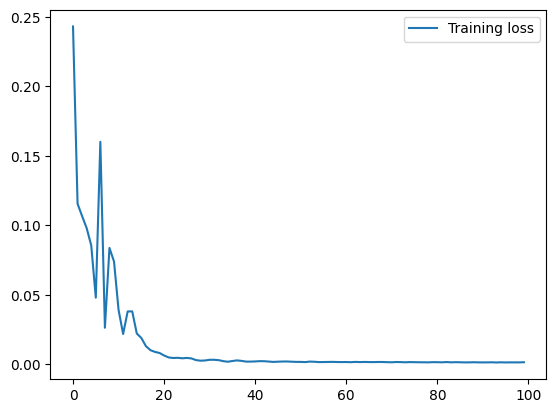

In [32]:
# Training
num_epochs = 100
hist = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if (t+1) % 10 == 0:
        print(f"Epoch {t+1} MSE: {loss.item()}")
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(hist, label='Training loss')
plt.legend()
plt.show()



In [33]:
# Testing
y_test_pred = model(x_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

trainScore = sqrt(mean_squared_error(y_train, y_train_pred))
testScore = sqrt(mean_squared_error(y_test, y_test_pred))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 2.30 RMSE
Test Score: 8.83 RMSE


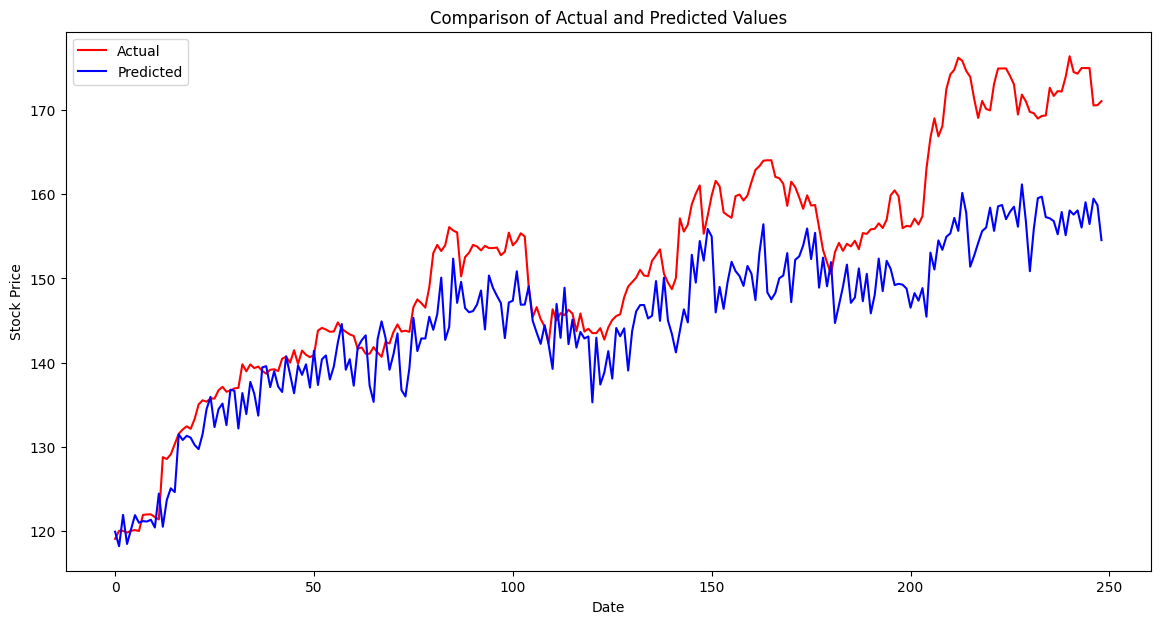

In [34]:
# Visualization
test_results = pd.DataFrame({
    'Original': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
})
plt.figure(figsize=(14, 7))
plt.plot(test_results['Original'], color='red', label='Actual')
plt.plot(test_results['Predicted'], color='blue', label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [35]:
y_test = y_test.detach().numpy() if isinstance(y_test, torch.Tensor) else y_test
y_test_pred = y_test_pred.detach().numpy() if isinstance(y_test_pred, torch.Tensor) else y_test_pred
# Create a DataFrame for dates
dates = df_stock[len(df_stock)-len(y_test):].index.to_series().reset_index(drop=True)

# Create a DataFrame from the original and predicted values
comparison_df = pd.DataFrame({
    'Date': dates,
    'Original': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
})

# Display the DataFrame
comparison_df

,Date,Original,Predicted
0,2017-01-17,119.040001,119.885979
1,2017-01-18,120.000000,118.162285
2,2017-01-19,119.989998,121.886223
3,2017-01-20,119.779999,118.429451
4,2017-01-23,120.000000,120.152824
...,...,...,...
244,2017-12-25,175.009995,159.057343
245,2017-12-26,175.009995,156.473969
246,2017-12-27,170.570007,159.484314
247,2017-12-28,170.599991,158.709030


**Random Forest Model**

Test RMSE: 1.6325361514342895


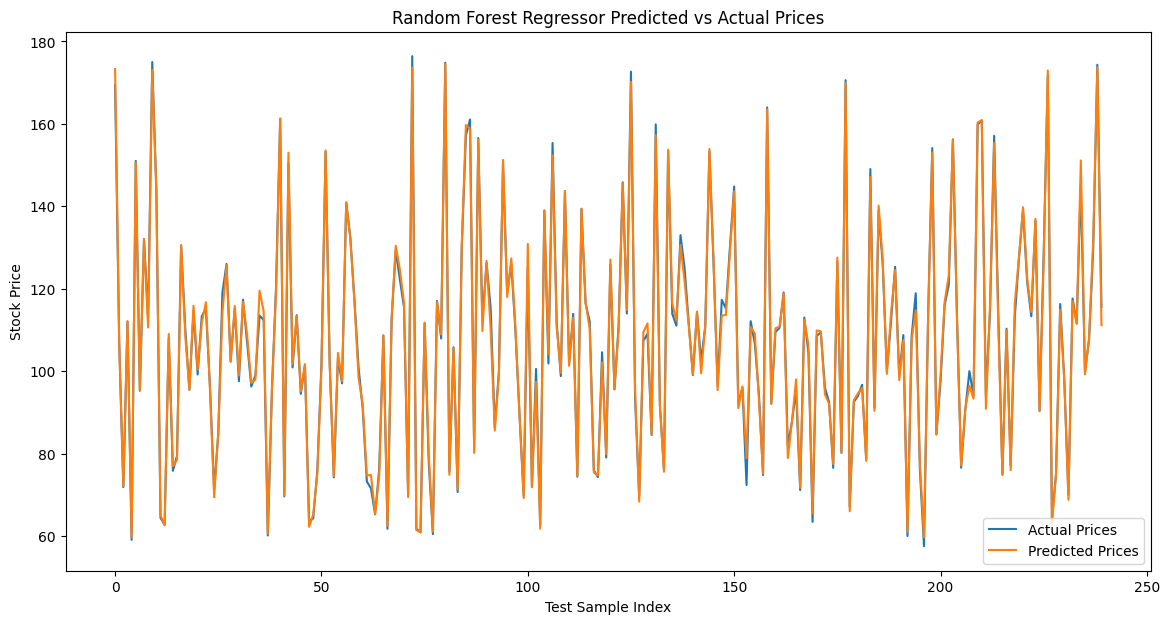

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib.pyplot as plt

# Load and preprocess the data
df_stock = pd.read_csv('AAPL.csv')
df_stock['Close'].fillna(method='ffill', inplace=True)

# Scaling the 'Close' prices
scaler = MinMaxScaler(feature_range=(-1, 1))
df_stock['Close'] = scaler.fit_transform(df_stock[['Close']].values)

# Feature Engineering: Creating lagged features
look_back = 60
for i in range(1, look_back+1):
    df_stock[f'lag_{i}'] = df_stock['Close'].shift(i)

# Drop rows with NaN values
df_stock.dropna(inplace=True)

# Features and target
X = df_stock[[f'lag_{i}' for i in range(1, look_back+1)]].values
y = df_stock['Close'].values

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

# Inverse transform predictions and actual values to original scale for evaluation
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print('Test RMSE:', rmse)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.title('Random Forest Regressor Predicted vs Actual Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Random forest model:2**

Test RMSE: 27.421297851788605


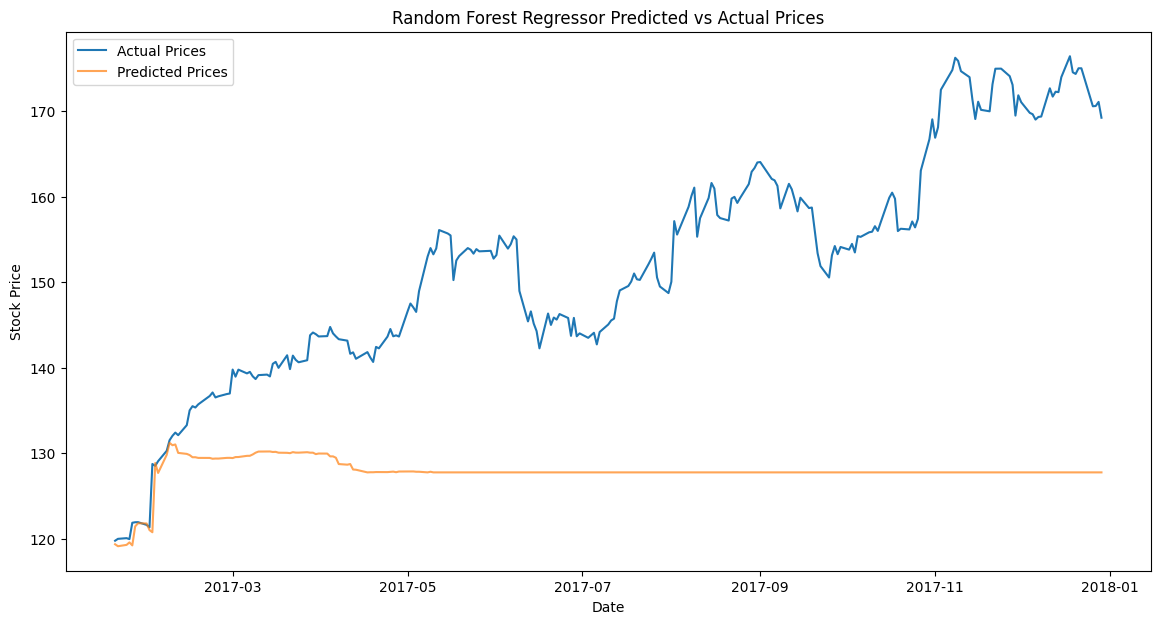

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib.pyplot as plt

# Load and preprocess the data
df_stock = pd.read_csv('AAPL.csv')
df_stock['Close'].fillna(method='ffill', inplace=True)

# Scaling the 'Close' prices
scaler = MinMaxScaler(feature_range=(-1, 1))
df_stock['Close'] = scaler.fit_transform(df_stock[['Close']].values)

# Feature Engineering: Creating lagged features
look_back = 60
for i in range(1, look_back+1):
    df_stock[f'lag_{i}'] = df_stock['Close'].shift(i)

# Preserve dates for plotting
df_stock['date'] = pd.to_datetime(df_stock['Date'])  # Assuming 'Date' column is in your csv
df_stock.set_index('date', inplace=True)  # Setting date as index

# Drop rows with NaN values due to shifting
df_stock.dropna(inplace=True)

# Features and target
X = df_stock[[f'lag_{i}' for i in range(1, look_back+1)]]
y = df_stock['Close']

# Splitting the dataset into training and test sets, ensuring dates are preserved
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
test_dates = X_test.index  # Storing test dates for plotting

# Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

# Inverse transform predictions and actual values to original scale for evaluation
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.values.reshape(-1, 1))

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print('Test RMSE:', rmse)

# Plot the results using dates
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_rescaled, label='Actual Prices')
plt.plot(test_dates, y_pred_rescaled, label='Predicted Prices', alpha=0.7)
plt.title('Random Forest Regressor Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**CNN MODEL**

In [ ]:
import os
import numpy as np
import pandas as pd
from pylab import plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



In [ ]:
# Data Loading
dates = pd.date_range('2013-01-02','2017-12-29',freq='B')
df1 = pd.DataFrame(index=dates)
df_ibm = pd.read_csv('AAPL.csv', parse_dates=True, index_col=0)
df_stock = df1.join(df_ibm)
df_stock = df_stock[['Close']].dropna()
df_stock


,Close
2013-01-02,78.432854
2013-01-03,77.442856
2013-01-04,75.285713
2013-01-07,74.842857
2013-01-08,75.044289
...,...
2017-12-22,175.009995
2017-12-26,170.570007
2017-12-27,170.600006
2017-12-28,171.080002


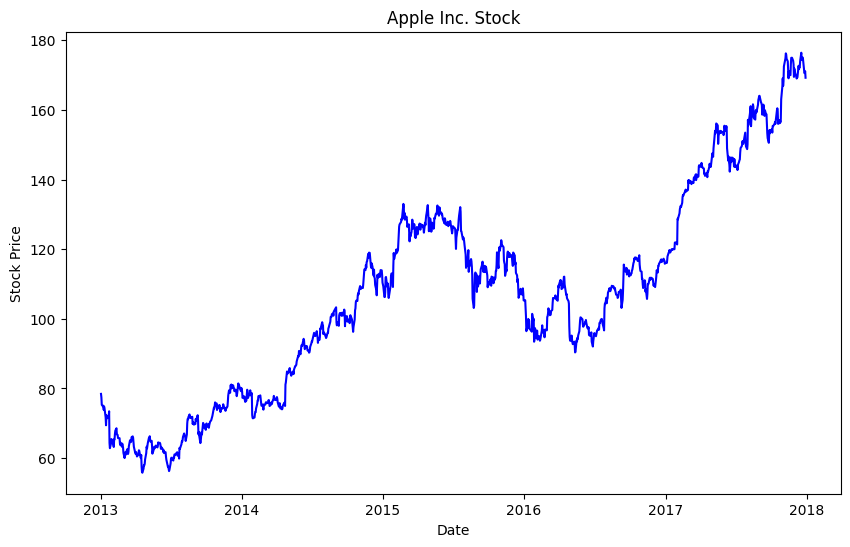

In [ ]:
# Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(df_stock['Close'], color='blue')
plt.title('Apple Inc. Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()



In [ ]:
# Data Preparation
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size, :-1]
    y_train = data[:train_set_size, -1]
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1]
    return [x_train, y_train, x_test, y_test]

look_back = 60
x_train, y_train, x_test, y_test = load_data(df_stock, look_back)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).view([x_train.shape[0], 1, x_train.shape[1]])
x_test = torch.from_numpy(x_test).type(torch.Tensor).view([x_test.shape[0], 1, x_test.shape[1]])
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)



In [ ]:
# CNN Model Definition
class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * (look_back//2//2), output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

output_dim = 1
model = CNN(output_dim=output_dim)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the Model
num_epochs = 100
for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred.squeeze(), y_train)
    if (t+1) % 10 == 0:
        print(f'Epoch {t+1}, Loss: {loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Making Predictions
model.eval()
y_test_pred = model(x_test)

# Evaluate the Model
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
trainScore = np.sqrt(mean_squared_error(y_train, y_train_pred))
testScore = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))



RuntimeError: mat1 and mat2 shapes cannot be multiplied (959x896 and 960x1)

In [ ]:
# Plotting the Predictions
plt.figure(figsize=(14,7))
plt.plot(y_test, color='red', label='Actual')
plt.plot(y_test_pred, color='blue', label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


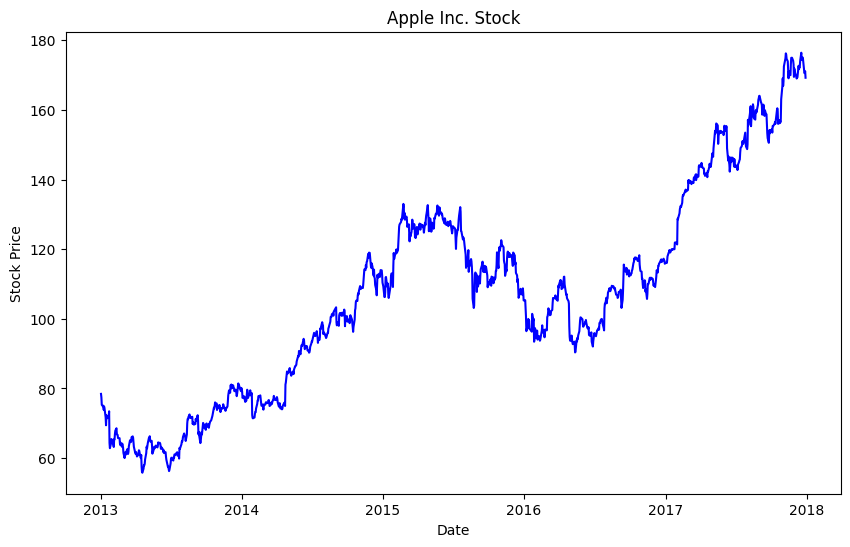

RuntimeError: mat1 and mat2 shapes cannot be multiplied (959x896 and 960x1)

In [ ]:
import os
import numpy as np
import pandas as pd
from pylab import plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Data Loading
dates = pd.date_range('2013-01-02','2017-12-29',freq='B')
df1 = pd.DataFrame(index=dates)
df_ibm = pd.read_csv('AAPL.csv', parse_dates=True, index_col=0)
df_stock = df1.join(df_ibm)
df_stock = df_stock[['Close']].dropna()

# Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(df_stock['Close'], color='blue')
plt.title('Apple Inc. Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# Data Preparation
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size, :-1]
    y_train = data[:train_set_size, -1]
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1]
    return [x_train, y_train, x_test, y_test]

look_back = 60
x_train, y_train, x_test, y_test = load_data(df_stock, look_back)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor).view([x_train.shape[0], 1, x_train.shape[1]])
x_test = torch.from_numpy(x_test).type(torch.Tensor).view([x_test.shape[0], 1, x_test.shape[1]])
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# CNN Model Definition
class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 15, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

output_dim = 1
model = CNN(output_dim=output_dim)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the Model
num_epochs = 100
for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred.squeeze(), y_train)
    if (t+1) % 10 == 0:
        print(f'Epoch {t+1}, Loss: {loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Making Predictions
model.eval()
y_test_pred = model(x_test)

# Evaluate the Model
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
trainScore = np.sqrt(mean_squared_error(y_train, y_train_pred))
testScore = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

# Plotting the Predictions
plt.figure(figsize=(14,7))
plt.plot(y_test, color='red', label='Actual')
plt.plot(y_test_pred, color='blue', label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()